In [36]:
import numpy as np
import pandas as pd

np.random.seed(seed=42)

metasamples = pd.read_excel('../Metadata.xlsx')
metasamples['SAMPLE_ID'] = metasamples['SAMPLE_ID'].astype(str)
metasamples.index = [x.strip() for x in metasamples['SAMPLE_ID'] + '-' + metasamples['PATIENT_ID']]

# Keep only samples that are tumor-normal pair and labeled as included
meta_filtered = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                                & (metasamples['TUMOR_ONLY'] == "No")
                                & (metasamples['VAR2'].notnull())
                                #& (metasamples['baseline_1_more'] == "Y")
                                #& (metasamples['baseline_1'] == "Y")
                                #& (metasamples['MSI_ISH'] == 'MSS')
                                & (metasamples['SAMPLE_TYPE'] != "PDX")
                                & (metasamples['SAMPLE_TYPE'] != "gDNA"), :]
meta_filtered = meta_filtered.drop(labels=['4179_77_cfDNA-VHIO_35'])
#meta_filtered = meta_filtered.drop(labels=['M18_2959_80_tumor-VHIO_38'])
meta_filtered = meta_filtered.drop(labels=['JAM_16_19733_A10_MPP216_L18_4331_82_tumor-VHIO_39'])

# Load and filter spectra files
spectra_snp = pd.read_csv('../analysis/merged_maf_spectra_snp_filtered.txt', sep='\t', index_col=0, header=0)
samples_snp = np.intersect1d(meta_filtered.index, spectra_snp.columns)
spectra_snp = spectra_snp.loc[:, samples_snp]
spectra_snp = spectra_snp.dropna()

spectra_indel = pd.read_csv('../analysis/merged_maf_spectra_indel_filtered.txt', sep='\t', index_col=0, header=0)
samples_indel = np.intersect1d(meta_filtered.index, spectra_indel.columns)
spectra_indel = spectra_indel.loc[:, samples_indel]
spectra_indel = spectra_indel.dropna()

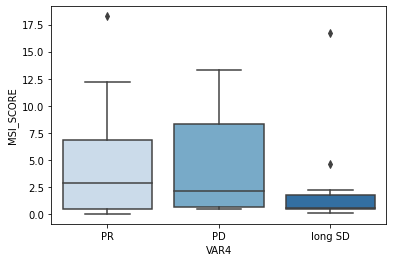

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=meta_filtered["VAR4"], y=meta_filtered["MSI_SCORE"].astype(float), palette="Blues")
plt.savefig('MSI_score_distribution_signatures.pdf')
plt.show()

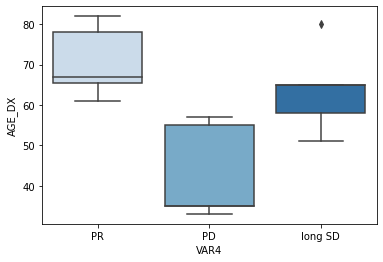

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=meta_filtered["VAR4"], y=meta_filtered["AGE_DX"].astype(float), palette="Blues")
plt.savefig('Age_distribution_signatures.pdf')
plt.show()

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import umap

color_map = ["red", "green", "blue", "orange", "cyan", "yellow", "orchid", 
             "saddlebrown", "darkcyan", "gray", "darkred", "darkgreen", "darkblue", 
             "antiquewhite", "bisque", "black", "slategray", "gold", "floralwhite",
             "aliceblue", "plum", "cadetblue", "coral", "olive", "khaki", "lightsalmon"]

def plot_heatmap(data, meta, title, filename):
    figsize = (16,16)
    cmap = "bwr"
    vmax = None
    vmin = None

    var2 = meta['VAR2'].copy()
    var2.loc[var2 == 'E'] = color_map[1]
    var2.loc[var2 == 'F'] = color_map[2]
    var2.loc[var2.isna()] = color_map[0]
    var2_colors = var2.to_list()
    
    var4 = meta['VAR4'].copy()
    var4.loc[var4 == 'CR'] = color_map[4]
    var4.loc[var4 == 'PD'] = color_map[5]
    var4.loc[var4 == 'PR'] = color_map[6]
    var4.loc[var4 == 'long SD'] = color_map[7]
    var4.loc[var4 == 'short SD'] = color_map[8]
    var4.loc[var4.isna()] = color_map[0]
    var4_colors = var4.to_list()
    
    var5 = meta['MSI_ISH'].copy()
    var5.loc[var5 == 'MSS'] = color_map[9]
    var5.loc[var5 == 'MSI'] = color_map[10]
    var5.loc[var5.isna()] = color_map[0]
    var5_colors = var5.to_list()

    ax = sns.clustermap(data,
                        z_score=None,
                        standard_scale=None,
                        cmap=cmap,
                        rasterized=True,
                        yticklabels=1,
                        metric='euclidean',
                        method='complete',
                        row_colors=[var2_colors, var4_colors, var5_colors],
                        vmax=vmax,
                        vmin=vmin)
    
    handles = [Patch(color=color_map[0], label='Na'),
               Patch(color=color_map[1], label='E'),
               Patch(color=color_map[2], label='F'),
               Patch(color=color_map[4], label='CR'),
               Patch(color=color_map[5], label='PD'),
               Patch(color=color_map[6], label='PR'),
               Patch(color=color_map[7], label='long SD'),
               Patch(color=color_map[8], label='short SD'),
               Patch(color=color_map[9], label='MSS'),
               Patch(color=color_map[10], label='MSI')]
    ax.ax_heatmap.set_title(title, fontsize=18)
    ax.ax_heatmap.set_xlabel("Signatures",fontsize=10)
    ax.ax_heatmap.set_ylabel("Samples", fontsize=10)
    ax.ax_heatmap.tick_params(labelsize=10)
    ax.ax_row_dendrogram.legend(handles=handles, loc="lower left")
    ax.savefig(filename)
    
    
def plot_pca(data, colors, labels, title, filename):

    if data.shape[1] > 2:
        reduced_data = PCA(whiten=False, n_components=2).fit_transform(data)
    else:
        reduced_data = data.to_numpy()
        
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(reduced_data[:, 0],
                    reduced_data[:, 1], 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=40)

    ax.set_xlabel('PCA1', fontsize=16)
    ax.set_ylabel('PCA2', fontsize=16)
    ax.set_title(title, size=18)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=16)
    fig.savefig(filename)
    
def plot_umap(data, colors, labels, title, filename):
    
    if data.shape[1] > 2:
        reduced_data = umap.UMAP(n_neighbors=5, min_dist=0.01, random_state=42,
                                 n_components=2, metric='euclidean').fit_transform(data)
    else:
        reduced_data = data.to_numpy()
        
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(reduced_data[:, 0],
                    reduced_data[:, 1], 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=40)

    ax.set_xlabel('UMAP1', fontsize=16)
    ax.set_ylabel('UMAP2', fontsize=16)
    ax.set_title(title, size=18)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=16)
    fig.savefig(filename)

In [40]:
def make_plots(data, meta, name):
    
    plot_heatmap(data, 
                 meta, 
                 'Signatures_{}'.format(name), 
                 'Signatures_{}.pdf'.format(name))
    
    
    meta_slice = meta[meta['VAR2'].notnull()]
    data_slice = data.loc[meta_slice.index.tolist(), :]
    var2_colors = [0 if x == 'E' else 1 for x in meta_slice['VAR2']]
    plot_pca(data_slice, 
             colors=var2_colors,
             labels=['E', 'F'],
             title='Signatures {} (VAR2)'.format(name),
             filename='pca_signature_{}_var2.pdf'.format(name))
    plot_umap(data_slice, 
              colors=var2_colors,
              labels=['E', 'F'],
              title='Signatures {} (VAR2)'.format(name),
              filename='umap_signature_{}_var2.pdf'.format(name))

    meta_slice = meta[meta['VAR4'].notnull()]
    data_slice = data.loc[meta_slice.index.tolist(), :]
    var4 = meta_slice['VAR4'].copy()
    var4.loc[var4 == 'CR'] = 1
    var4.loc[var4 == 'PD'] = 2
    var4.loc[var4 == 'PR'] = 3
    var4.loc[var4 == 'long SD'] = 4
    var4.loc[var4 == 'short SD'] = 5
    var4_colors = var4.to_list()
    labels = ['CR', 'PD', 'PR', 'long SD', 'short SD']
    plot_pca(data_slice, 
             colors=var4_colors,
             labels=labels,
             title='Signatures {} (VAR4)'.format(name),
             filename='pca_signature_{}_var4.pdf'.format(name))
    plot_umap(data_slice, 
              colors=var4_colors,
              labels=labels,
              title='Signatures {} (VAR4)'.format(name),
              filename='umap_signature_{}_var4.pdf'.format(name))

   * Creating output dir at signatures_snp
   * Using cosmic3_exome signatures
   * Saving ARD-NMF outputs to signatures_snp/nmf_output.h5
   * Running ARD-NMF...
	0/9: nit=  857 K=3 	del=0.000000703
	1/9: nit=  318 K=2 	del=0.000000998
	2/9: nit=  381 K=2 	del=0.000000992
	3/9: nit=  728 K=2 	del=0.000000852
	4/9: nit= 2121 K=3 	del=0.000000924
	5/9: nit= 1511 K=3 	del=0.000000920
	6/9: nit=  176 K=2 	del=0.000000932
	7/9: nit= 2157 K=3 	del=0.000000945
	8/9: nit= 2219 K=3 	del=0.000000978
	9/9: nit=  750 K=3 	del=0.000000944


/Users/jfnavarro/anaconda3/lib/python3.8/site-packages/signatureanalyzer/utils.py:459: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(file) as f:


   * Run 5 had lowest objective with mode (n=6) K = 3.
   * Saving report plots to signatures_snp


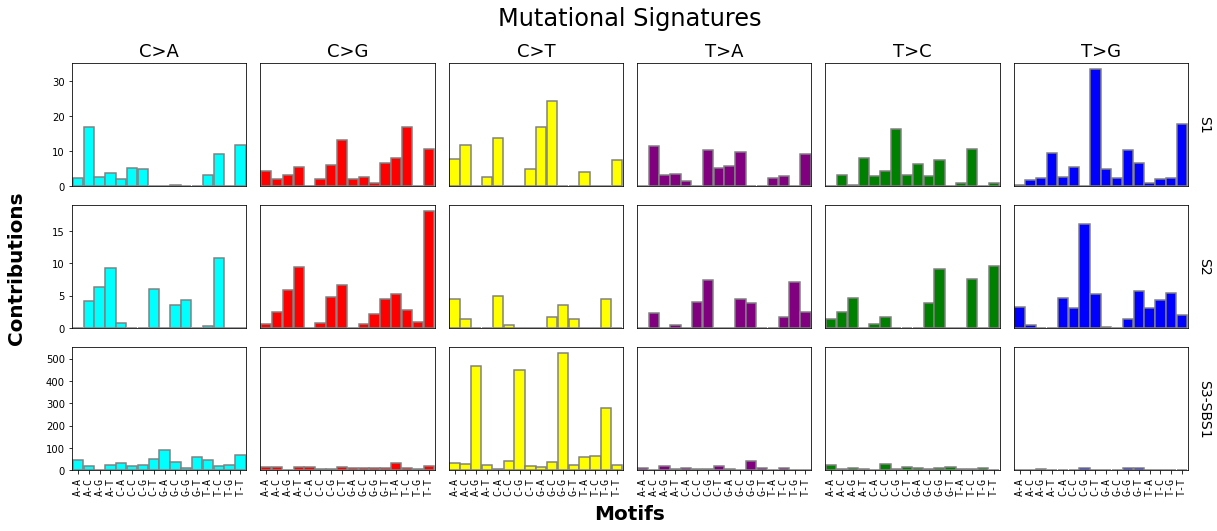

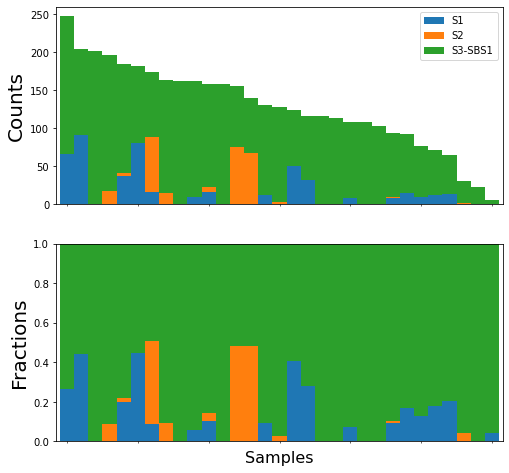

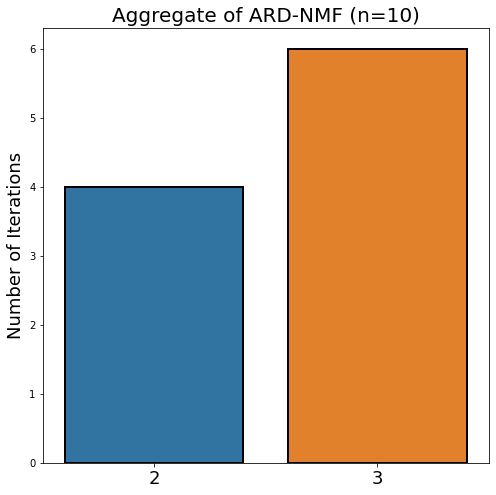

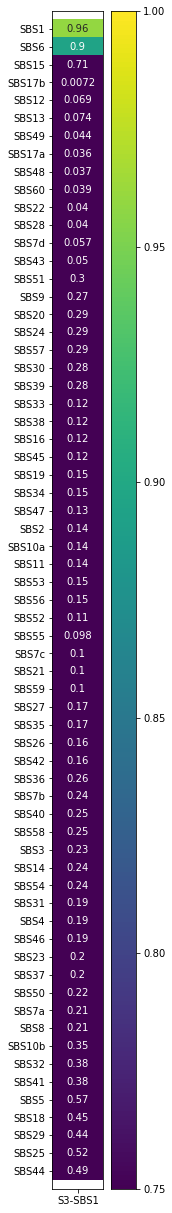

In [41]:
import signatureanalyzer as sa
import os
import shutil

shutil.rmtree('signatures_snp', ignore_errors=True)
results_snp = sa.run_spectra(spectra_snp.copy(), outdir='signatures_snp', 
                             cosmic="cosmic3_exome", verbose=False)

out_results = os.path.join('signatures_snp', 'nmf_output.h5')

results_snp = dict()
#results_snp['H'] = pd.read_hdf(out_results, 'H')
#results_snp['W'] = pd.read_hdf(out_results, 'W')
results_snp['Hraw'] = pd.read_hdf(out_results, 'Hraw')
results_snp['Wraw'] = pd.read_hdf(out_results, 'Wraw')
results_snp['feature_signatures'] = pd.read_hdf(out_results, 'signatures')
results_snp['markers'] = pd.read_hdf(out_results, 'markers')
#results_snp['cosine'] = pd.read_hdf(out_results, 'cosine')
#results_snp['log'] = pd.read_hdf(out_results, 'log')

In [42]:
from collections import defaultdict
from twobitreader import TwoBitFile

COMPL = {"A":"T","T":"A","G":"C","C":"G"}

def compl(seq, reverse=False):
    return ''.join([COMPL[x] if x in COMPL.keys() else x for x in (reversed(seq) if reverse else seq)])

snp_to_genes = defaultdict(list)

samples = meta_filtered.index

hg = TwoBitFile('../analysis/hg38.2bit')
maf = pd.read_csv('../analysis/merged_maf_filtered.txt', sep='\t', index_col=None, header=0)
for index, row in maf.iterrows():
    gene = row['Hugo_Symbol']
    ref = row['Reference_Allele']
    alt = row['Tumor_Seq_Allele2']
    chrm = row['Chromosome']
    mut_type = row['Variant_Type']
    sample = row['Tumor_Sample_Barcode']
    pos = row['Start_Position']
    if mut_type == 'SNP' and sample in samples:
        c = hg[chrm][pos-2:pos+1].upper()
        m = len(c) // 2
        contig = ref + alt + c[m - 1] + c[m + 1] if ref in 'AC' else compl(ref + alt + c[m + 1] + c[m - 1])
        snp_to_genes[contig].append(gene)

In [43]:
from gprofiler import gprofiler
from tqdm import tqdm

query = results_snp['feature_signatures']
subtype_key = 'max_id'

for cat in tqdm(query[subtype_key].astype("category").cat.categories, desc="Computing overlaps"):
    query_genes = list()
    for w in query[query[subtype_key]==cat].index:
        query_genes += snp_to_genes[w]
        
    print('Number of genes {} in {}'.format(len(query_genes), cat))
    
    enrichment = gprofiler(query_genes, ordered_query=True, src_filter=['GO:BP'])

    if enrichment is not None:
        enrichment['subtype'] = cat
        enrichment = enrichment.loc[:,['subtype','p.value','term.size','overlap.size',
                                       'term.name','domain','intersection']].sort_values('p.value')
        enrichment.to_csv('Pathways_signature_{}.tsv'.format(cat), sep='\t', header=True, index=True)
    else:
        print("* no overlaps found in {}.".format(cat))

Computing overlaps:   0%|          | 0/1 [00:00<?, ?it/s]

Number of genes 2413 in 3


Computing overlaps: 100%|██████████| 1/1 [00:28<00:00, 28.16s/it]


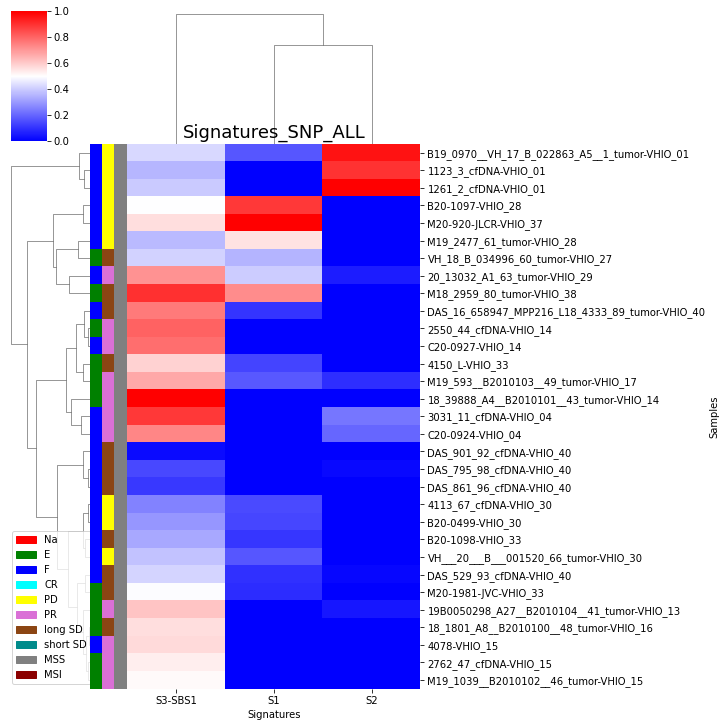

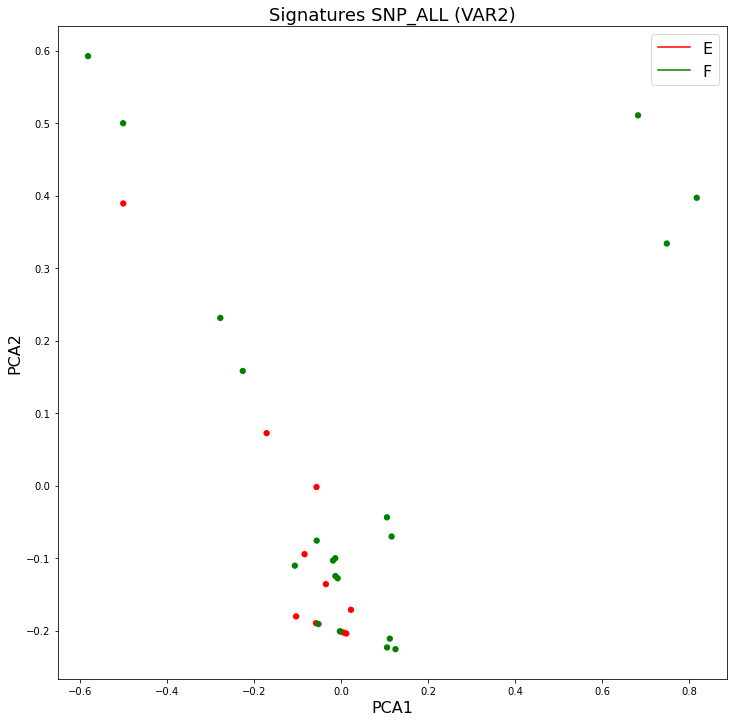

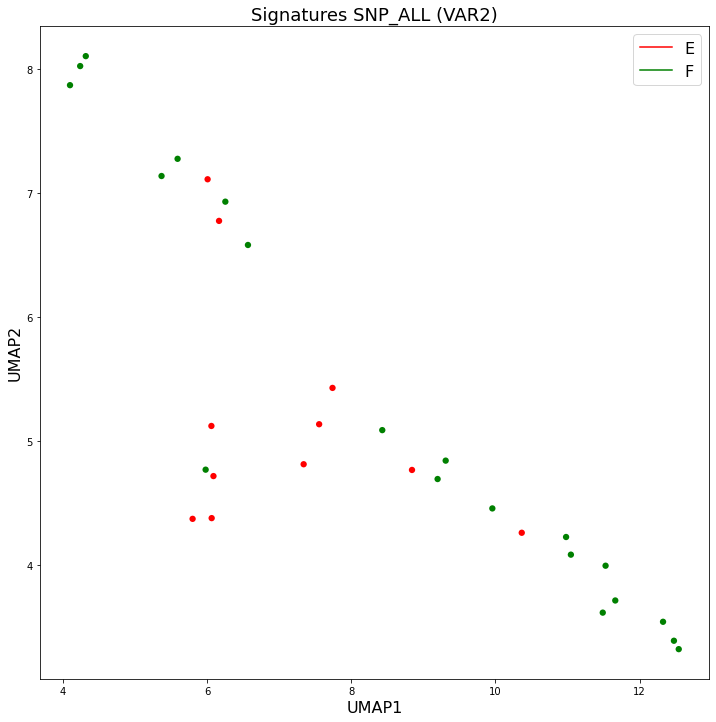

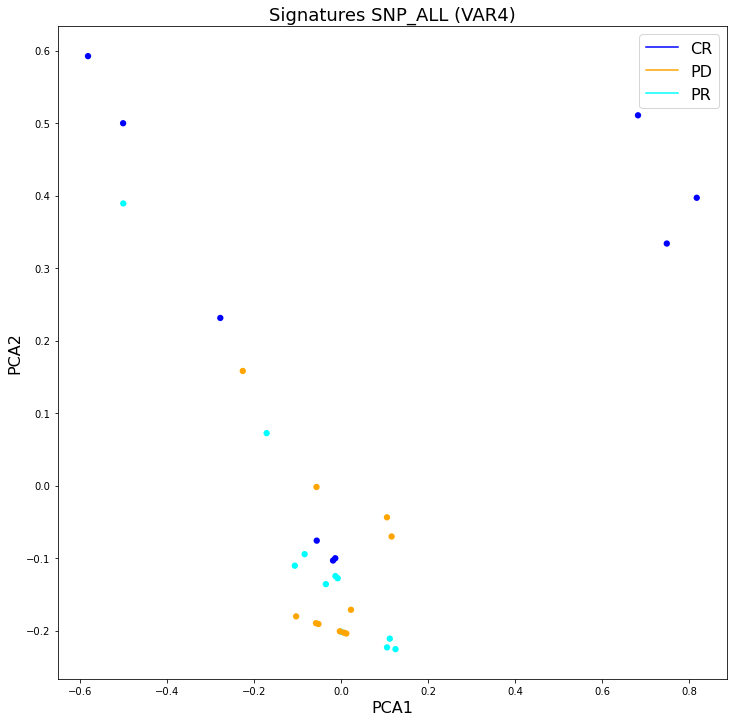

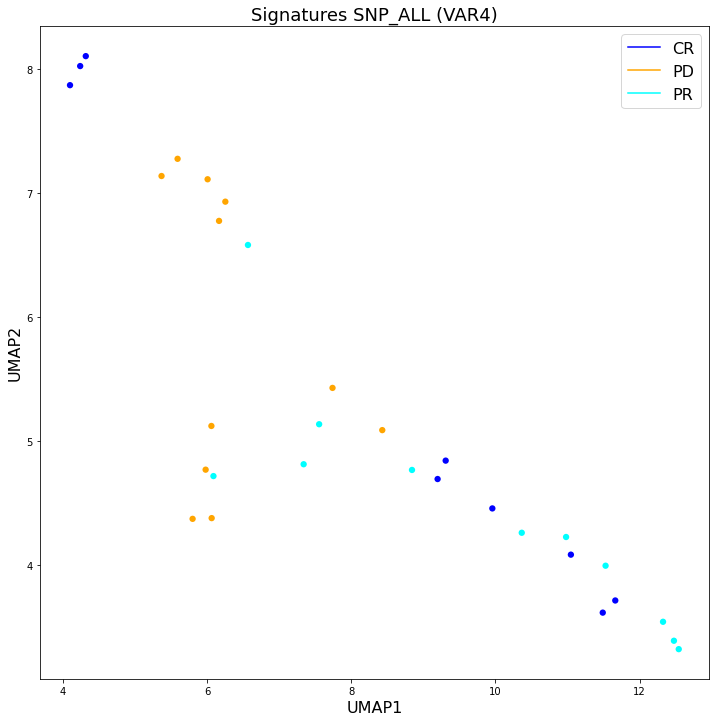

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer 
from sklearn.preprocessing import MaxAbsScaler

data = results_snp['Hraw'].dropna()

data_norm = pd.DataFrame(data=MaxAbsScaler().fit_transform(data),
                         index=data.index,
                         columns=data.columns)

#data_norm = pd.DataFrame(data=MinMaxScaler().fit_transform(data),
#                         index=data.index,
#                         columns=data.columns)

#data_norm = pd.DataFrame(data=StandardScaler().fit_transform(data),
#                         index=data.index,
#                         columns=data.columns)

make_plots(data_norm, meta_filtered.reindex(data_norm.index), 'SNP_ALL')

   * Creating output dir at signatures_indel
   * Using cosmic3_ID signatures
   * Saving ARD-NMF outputs to signatures_indel/nmf_output.h5
   * Running ARD-NMF...
	0/9: nit=   37 K=1 	del=0.000000898
	1/9: nit=   69 K=2 	del=0.000000128
	2/9: nit=   37 K=1 	del=0.000000825
	3/9: nit=  239 K=2 	del=0.000000922
	4/9: nit=   37 K=1 	del=0.000000827
	5/9: nit=  212 K=3 	del=0.000000894
	6/9: nit=   75 K=2 	del=0.000000902
	7/9: nit=   37 K=1 	del=0.000000896
	8/9: nit=   41 K=1 	del=0.000000895
	9/9: nit=   50 K=1 	del=0.000000821


/Users/jfnavarro/anaconda3/lib/python3.8/site-packages/signatureanalyzer/utils.py:459: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(file) as f:


   * Run 0 had lowest objective with mode (n=6) K = 1.
   * Saving report plots to signatures_indel


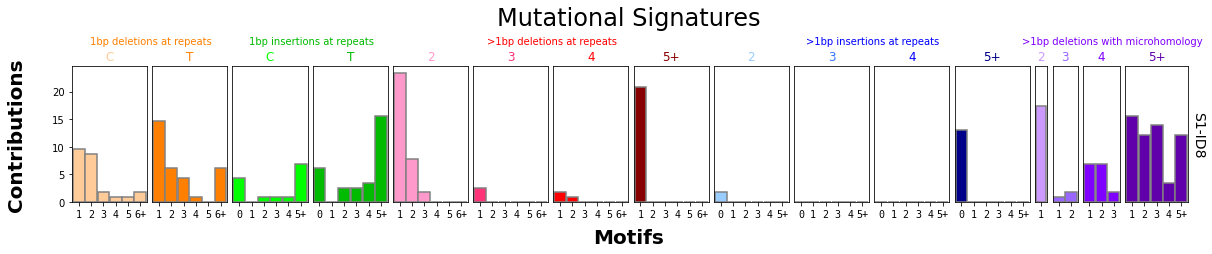

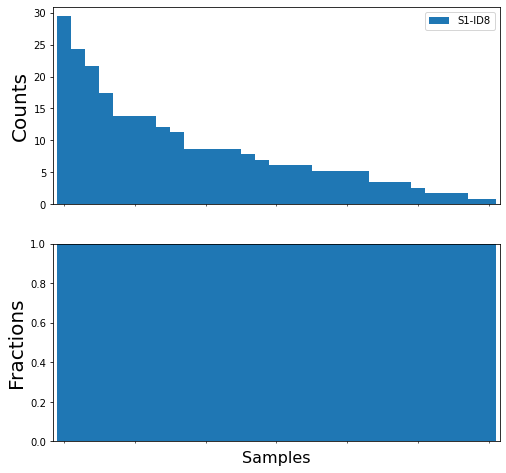

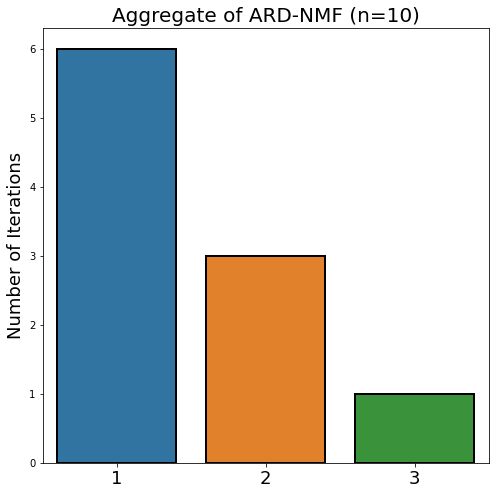

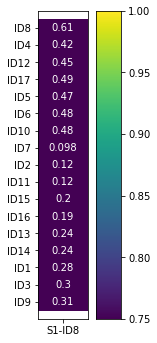

In [45]:
shutil.rmtree('signatures_indel', ignore_errors=True)
results_indel = sa.run_spectra(spectra_indel.copy(), outdir='signatures_indel', 
                               cosmic="cosmic3_ID", verbose=False)

out_results = os.path.join('signatures_indel', 'nmf_output.h5')

results_indel = dict()
#results_indel['H'] = pd.read_hdf(out_results, 'H')
#results_indel['W'] = pd.read_hdf(out_results, 'W')
results_indel['Hraw'] = pd.read_hdf(out_results, 'Hraw')
results_indel['Wraw'] = pd.read_hdf(out_results, 'Wraw')
results_indel['feature_signatures'] = pd.read_hdf(out_results, 'signatures')
results_indel['markers'] = pd.read_hdf(out_results, 'markers')
#results_indel['cosine'] = pd.read_hdf(out_results, 'cosine')
#results_indel['log'] = pd.read_hdf(out_results, 'log')

ValueError: Linkage must be computed on at least two observations.

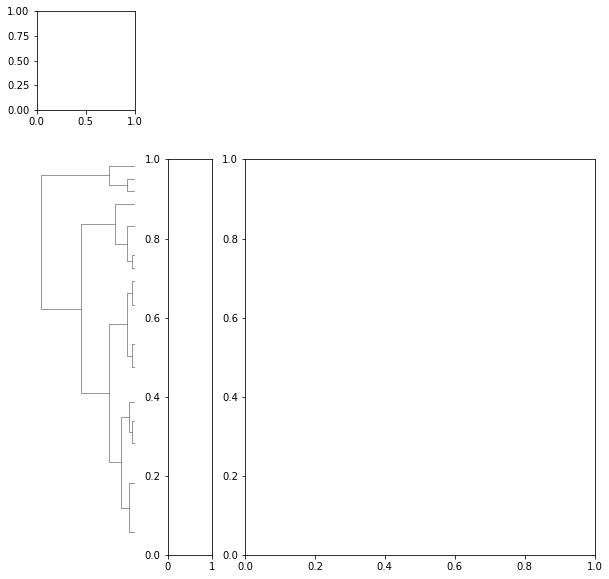

In [46]:
data = results_indel['Hraw'].dropna()

data_norm = pd.DataFrame(data=MaxAbsScaler().fit_transform(data),
                         index=data.index,
                         columns=data.columns)

#data_norm = pd.DataFrame(data=MinMaxScaler().fit_transform(data),
#                         index=data.index,
#                         columns=data.columns)

#data_norm = pd.DataFrame(data=StandardScaler().fit_transform(data),
#                         index=data.index,
#                         columns=data.columns)

make_plots(data_norm, meta_filtered.reindex(data_norm.index), 'INDEL_ALL')